In [1]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies
import os

os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import tensorflow as tf
import random
import keras
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model

from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')
from tabulate import tabulate

In [3]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [4]:
def performance_measure(model, test, timesteps):
    """
    Evaluate the performance of a model on test data.

    Parameters:
    - model: The trained model to be evaluated.
    - test: The test data.
    - timesteps: Number of timesteps for each input sequence.

    Returns:
    - mse: Mean squared error between true and predicted values.
    - rmse: Root mean squared error between true and predicted values.
    - r: R-squared score between true and predicted values.
    - Y_test: True target values from the test data.
    - Y_pred: Predicted target values by the model.
    """
    X_test = []
    Y_test = []

    # Loop for creating input sequences and target values
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i - timesteps:i])
        Y_test.append(test[i][0])
        
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Prediction
    Y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = sqrt(mse)
    r_squared = r2_score(Y_test, Y_pred)
    
    return mse, rmse, r_squared, Y_test, Y_pred


In [5]:
# Function to plot the actual vs predicted data
def plot_data(Y_test, Y_pred, model_name):
    # Plot actual data in blue
    plt.plot(Y_test, c='r')
    
    # Plot predicted data in green
    plt.plot(Y_pred, c='g')
    
    # Label x-axis
    plt.xlabel('Day')
    
    # Label y-axis
    plt.ylabel('Price')
    
    # Title of the plot
    plt.title(f'Stock Prediction Graph using {model_name} model')
    
    # Adding legend for better understanding
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    
    # Display the plot
    plt.show()

In [6]:
def ema_signal(df, window=14):
    """
    Calculate exponential moving average (EMA) and generate a signal based on whether the price is above or below EMA.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Close' prices.
    - window (int): Window size for EMA calculation. Default is 14.

    Returns:
    - df (DataFrame): Input DataFrame with additional columns for EMA and EMA signal.
    """

    # Calculate exponential moving average
    ema = df['Close'].ewm(span=window, min_periods=window, adjust=False).mean()

    # Append EMA values to the DataFrame
    df['EMA'] = ema

    # Add a column indicating whether the price is above or below EMA
    df['EMA_discrete'] = np.where(df['Close'] > ema, 1, -1)

    return df




def stochastic_signal(df, period=14):
    """
    Calculate Stochastic Oscillator and discrete signals based on %K values.
    
    Parameters:
    df (DataFrame): Input DataFrame containing 'Low', 'High', and 'Close' columns.
    period (int): Period for calculating the rolling window (default is 14).

    Returns:
    DataFrame: DataFrame with Stochastic Oscillator values and discrete signals added.
    """

    # Calculate lowest low and highest high over the specified period
    df['Lowest_Low'] = df['Low'].rolling(window=period).min()
    df['Highest_High'] = df['High'].rolling(window=period).max()

    # Calculate %K (Stochastic Oscillator)
    df['%K'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100

    # Set Stochastic Oscillator equal to %K
    df['Stochastic'] = df['%K']
    
    # Shift %K by 1 time step to compare with previous value
    df['%K_previous'] = df['%K'].shift(1)

    # Determine trend opinion based on the change in %K value
    df['Stochastic_discrete'] = 0
    df.loc[df['%K'] > df['%K_previous'], 'Stochastic_discrete'] = 1  # If %K increases, trend is up
    df.loc[df['%K'] < df['%K_previous'], 'Stochastic_discrete'] = -1  # If %K decreases, trend is down

    # Drop temporary columns used for calculations
    df.drop(['Lowest_Low', 'Highest_High', '%K_previous'], axis=1, inplace=True)

    return df


def larry_williams_signal(df, period=14):
    """
    Calculate Larry Williams %R and discrete signals based on %R values.

    Parameters:
    df (DataFrame): Input DataFrame containing 'Low', 'High', and 'Close' columns.
    period (int): Period for calculating the rolling window (default is 14).

    Returns:
    DataFrame: DataFrame with Larry Williams %R values and discrete signals added.
    """

    # Calculate lowest low and highest high over the specified period
    df['Lowest_Low'] = df['Low'].rolling(window=period).min()
    df['Highest_High'] = df['High'].rolling(window=period).max()

    # Calculate %R (Larry Williams %R)
    df['%R'] = ((df['Highest_High'] - df['Close']) / (df['Highest_High'] - df['Lowest_Low'])) * -100
    
    df['Williams'] = df['%R']
    
    # Shift %R by 1 time step to compare with previous value
    df['%R_previous'] = df['%R'].shift(1)

    # Determine trend opinion based on the change in %R value
    df['Williams_discrete'] = 0
    df.loc[df['%R'] > df['%R_previous'], 'Williams_discrete'] = 1  # If %R increases, trend is up
    df.loc[df['%R'] < df['%R_previous'], 'Williams_discrete'] = -1  # If %R decreases, trend is down

    # Drop temporary columns used for calculations
    df.drop(['Lowest_Low', 'Highest_High', '%R_previous'], axis=1, inplace=True)

    return df




def ma_signal(df, window=14):
    """
    Calculate simple moving average (SMA) and generate a signal based on whether the price is above or below SMA.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Close' prices.
    - window (int): Window size for SMA calculation. Default is 14.

    Returns:
    - df (DataFrame): Input DataFrame with additional columns for SMA and SMA signal.
    """

    # Calculate simple moving average
    sma = df['Close'].rolling(window=window, min_periods=1).mean()

    # Append SMA values to the DataFrame
    df['SMA'] = sma

    # Add a column indicating whether the price is above or below SMA
    df['SMA_discrete'] = np.where(df['Close'] > sma, 1, -1)

    return df

In [7]:

def train_model(train, timesteps, batch, epochs, model_type):
    X_train = []
    Y_train = []
  
    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    reset_random_seeds()
    
    # Determine the RNN type based on the input model_type
    if model_type == 'LSTM':
        rnn_layer = LSTM
    elif model_type == 'SimpleRNN':
        rnn_layer = SimpleRNN
    elif model_type == 'GRU':
        rnn_layer = GRU
    else:
        raise ValueError("Invalid model type. Please choose 'LSTM', 'SimpleRNN', or 'GRU'.")
    
    # Adding Layers to the model
    model = Sequential()
    model.add(rnn_layer(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
                        activation='relu'))
    model.add(rnn_layer(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
    print(model.summary())
  
    # Training the data
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, verbose=0, shuffle=False)
    model.reset_states()
    return model

In [8]:
def inverse_transform(true, predicted, num_features, scaler):
    true = true.reshape(-1, 1)
    predicted = predicted.reshape(-1, 1)

    true = np.repeat(true, num_features, axis=1)
    predicted = np.repeat(predicted, num_features, axis=1)
    
    # Apply inverse_transform using the provided scaler
    true = scaler.inverse_transform(true)
    predicted = scaler.inverse_transform(predicted)

    # Discard repeated values
    true = true[:, 0]
    predicted = predicted[:, 0]

    return true, predicted


In [9]:
def aggregate_metric(mse_values, rmse_values, r_squared_values, weights=None):
    def scale_to_100(value):
        """Scale the value to a maximum of 100."""
        max_value = max(value)
        if max_value > 100:
            scale_factor = 100 / max_value
            scaled_values = [v * scale_factor for v in value]
            return scaled_values
        return value
    
    # Set default weights if not provided
    weights = [1, 1, 1] if weights is None else weights
    
    # Normalize weights to ensure they sum up to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    
    # Check if input values are single floats, convert them to lists
    if isinstance(mse_values, (float, np.float64)):
        mse_values = [mse_values]
    if isinstance(rmse_values, (float, np.float64)):
        rmse_values = [rmse_values]
    if isinstance(r_squared_values, (float, np.float64)):
        r_squared_values = [r_squared_values]
    
    # Invert MSE and RMSE values
    inverted_mse_values = [1 / mse for mse in mse_values]
    inverted_rmse_values = [1 / rmse for rmse in rmse_values]
    
    # Scale inverted MSE and RMSE values to 100 if necessary
    inverted_mse_values = scale_to_100(inverted_mse_values)
    inverted_rmse_values = scale_to_100(inverted_rmse_values)
    
    # Calculate aggregate metric by combining individual metrics with weights
    aggregate_metric_value = 0.0
    for mse, rmse, r_squared in zip(inverted_mse_values, inverted_rmse_values, r_squared_values):
        aggregate_metric_value += (weights[0] * mse) + (weights[1] * rmse) + (weights[2] * r_squared)
    
    return aggregate_metric_value

In [10]:
def evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test, timesteps, num_features, sc):
    models = [LSTM_model, SimpleRNN_model, GRU_model]
    model_names = ['LSTM', 'SimpleRNN', 'GRU']
    results = []

    for model, model_name in zip(models, model_names):
        mse, rmse, r_squared, true, predicted = performance_measure(model, test, timesteps)
        aggregate_metrics = aggregate_metric(mse, rmse, r_squared)
        results.append([model_name, mse, rmse, r_squared, aggregate_metrics])

    # Headers for the table
    headers = ["Model", "MSE", "RMSE", "R-Squared", "Aggregate Metrics"]

    # Create DataFrame
    df = pd.DataFrame(results, columns=headers)

    best_model = df[df['Aggregate Metrics'] == df['Aggregate Metrics'].max()]

    # Print the table with the best model highlighted
    print(best_model.to_string(index=False))

    best_model_name = best_model['Model'].values[0]
    if best_model_name == "LSTM":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'Multivariate-LSTM')
    elif best_model_name == "SimpleRNN":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'Multivariate-RNN')
    elif best_model_name == "GRU":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'Multivariate-GRU')

    return df

In [11]:
def split_data(series, train_percentage=0.7):
    # Calculate lengths for each split
    total_length = len(series)
    train_length = int(train_percentage * total_length)

    # Train data
    train_data = series[:train_length]

    # Test data
    test_data = series[train_length:]
    print(train_data.shape, test_data.shape)
    return train_data, test_data

In [12]:
def normalize_data(train_data, test_data):
    # Initialize MinMaxScaler
    sc = MinMaxScaler()
    
    # Fit and transform training data
    train_normalized = sc.fit_transform(train_data)
    
    # Transform test data
    test_normalized = sc.transform(test_data)
    print(train_normalized.shape, test_normalized.shape)
    return train_normalized, test_normalized, sc

### Data Preprocessing

In [13]:
reset_random_seeds()
df = pd.read_csv("NIFTY50.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Close
Date,,,,
02-01-2014,6301.250000,6358.299805,6211.299805,6221.149902
03-01-2014,6194.549805,6221.700195,6171.250000,6211.149902
06-01-2014,6220.850098,6224.700195,6170.250000,6191.450195
07-01-2014,6203.899902,6221.500000,6144.750000,6162.250000
08-01-2014,6178.049805,6192.100098,6160.350098,6174.600098


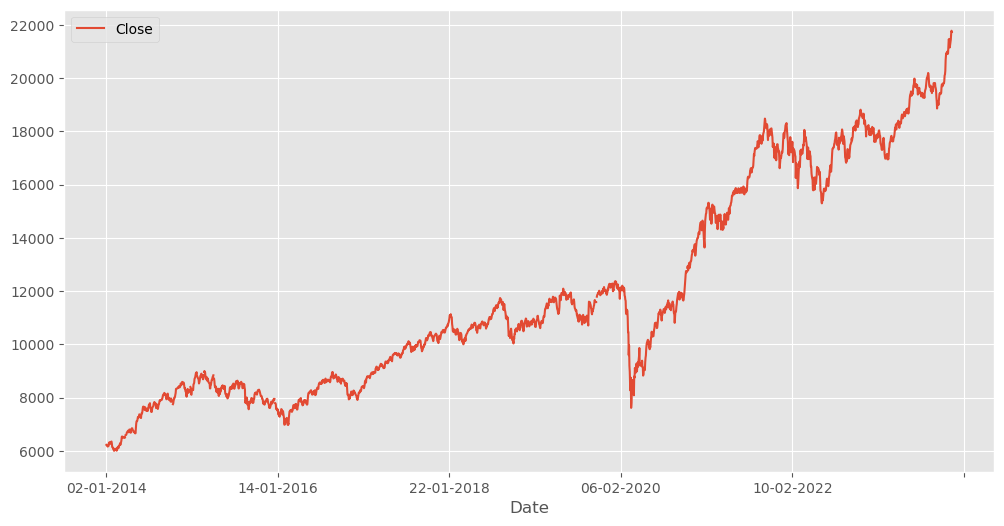

In [15]:
# Let's see a historical view of the closing price
df['Close'].plot(legend=True, figsize = (12, 6))
plt.show()

### Model Building

In [16]:
window = 5
timesteps = 5
batch_size = 64
num_epochs = 250
num_features = 5

(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Model: "sequential_1"
_____________________________________________

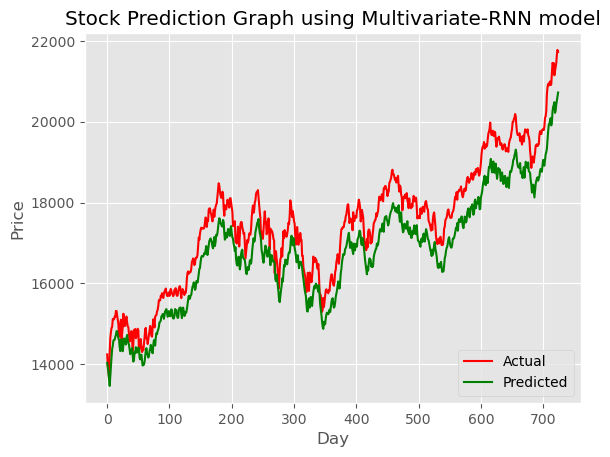

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 64)             17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              

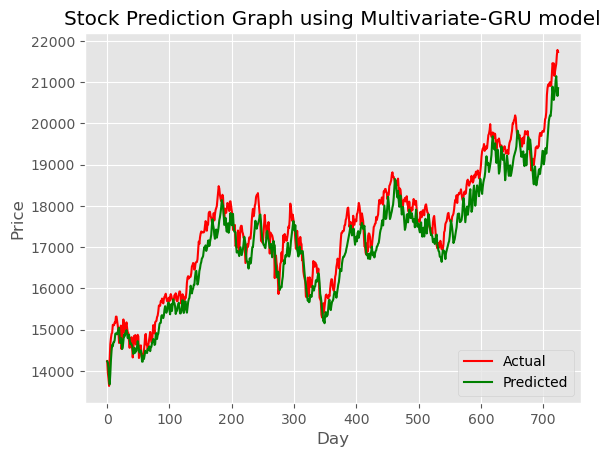

(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_7"
_____________________________________________

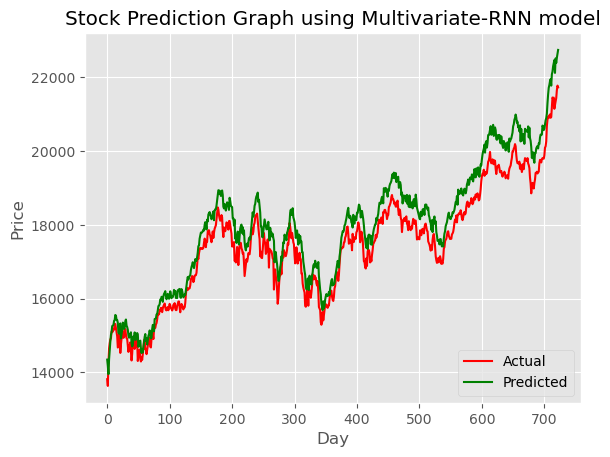

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 64)             17920     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape             

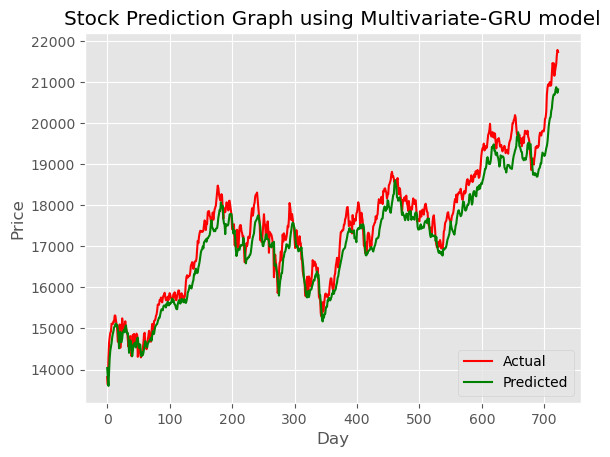

(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8, 64)             17920     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_13"
___________________________________________

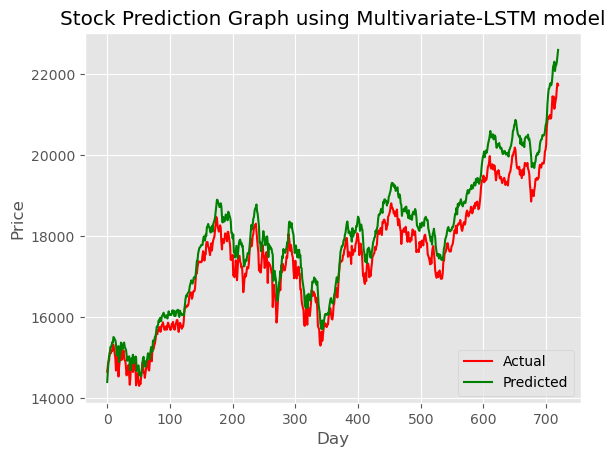

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8, 64)             17920     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape            

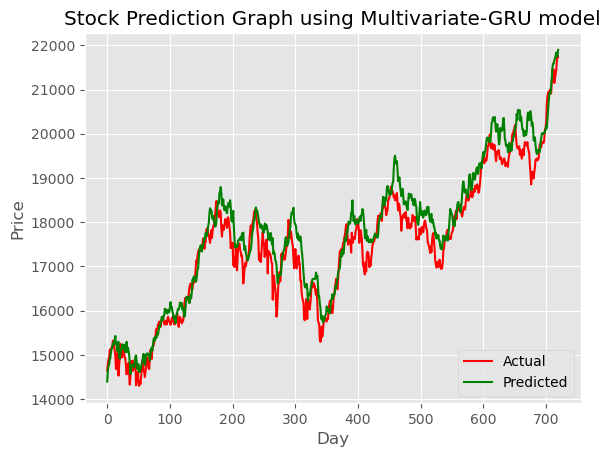

(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 14, 64)            17920     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_19"
___________________________________________

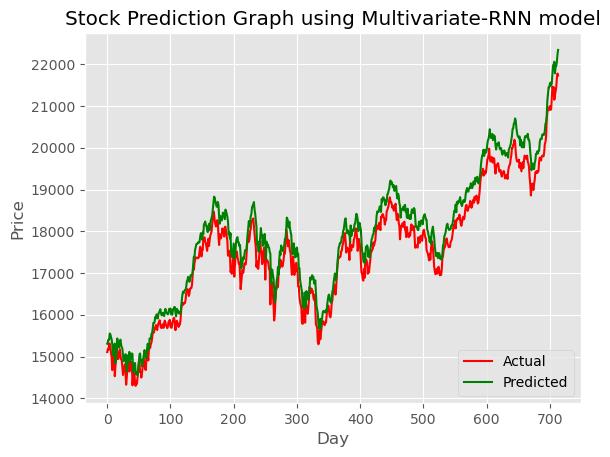

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 14, 64)            17920     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape            

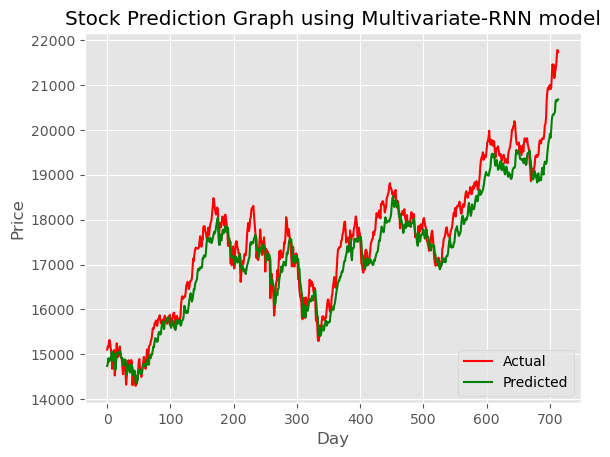

(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
(1697, 5) (728, 5)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 21, 64)            17920     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_25"
___________________________________________

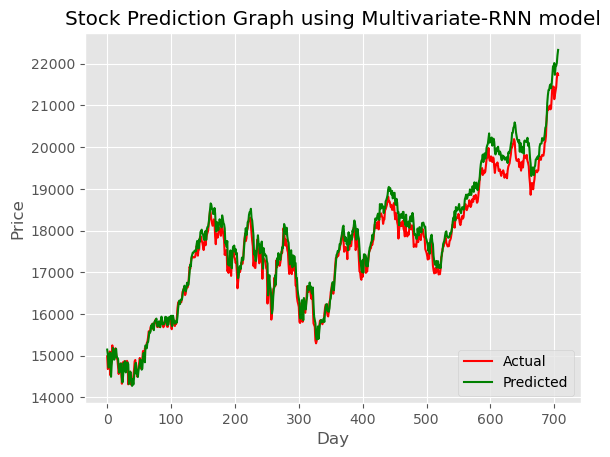

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 21, 64)            17920     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape            

In [ ]:
window_values = [3, 5, 8, 14, 21, 55]
timesteps_values = [3, 5, 8, 14, 21, 55]

# Create an empty DataFrame to collect data from all iterations
all_results = pd.DataFrame(columns=['Window', 'Timesteps', 'Model', 'MSE', 'RMSE', 'R-Squared', 'Aggregate Metrics'])

# Iterate over each combination of window and timesteps
for window in window_values:
    for timesteps in timesteps_values:
        # Perform data preprocessing with the current window and timesteps values
        df_temp = df.copy()  # Make a copy of the original DataFrame to avoid modifying it
        df_temp = larry_williams_signal(df_temp, window)
        df_temp = ema_signal(df_temp, window)
        df_temp = ma_signal(df_temp, window)
        df_temp = stochastic_signal(df_temp, window)
        df_temp.dropna(inplace=True)

        # Extract series and split data
        series_continuous = df_temp[['Close', 'EMA', 'SMA', 'Stochastic', 'Williams']]
        series_discrete = df_temp[['Close', 'EMA_discrete', 'SMA_discrete', 'Stochastic_discrete', 'Williams_discrete']]
        train_data_continuous, test_data_continuous = split_data(series_continuous, train_percentage=0.7)
        train_data_discrete, test_data_discrete = split_data(series_discrete, train_percentage=0.7)

        # Normalize data
        train_normalized_continuous, test_normalized_continuous, scalar_continuous = normalize_data(train_data_continuous, test_data_continuous)
        train_normalized_discrete, test_normalized_discrete, scalar_discrete = normalize_data(train_data_discrete, test_data_discrete)

        # Fit models and evaluate for continuous data
        LSTM_model_continuous = train_model(train_normalized_continuous, timesteps, batch_size, num_epochs, model_type='LSTM')
        SimpleRNN_model_continuous = train_model(train_normalized_continuous, timesteps, batch_size, num_epochs, model_type='SimpleRNN')
        GRU_model_continuous = train_model(train_normalized_continuous, timesteps, batch_size, num_epochs, model_type='GRU')
        results_continuous = evaluate_and_plot(LSTM_model_continuous, SimpleRNN_model_continuous, GRU_model_continuous, test_normalized_continuous, timesteps, num_features, scalar_continuous)
        results_continuous['Window'] = window
        results_continuous['Timesteps'] = timesteps
        results_continuous['Data_Type'] = 'Continuous'
        all_results = pd.concat([all_results, results_continuous], ignore_index=True)

        # Fit models and evaluate for discrete data
        LSTM_model_discrete = train_model(train_normalized_discrete, timesteps, batch_size, num_epochs, model_type='LSTM')
        SimpleRNN_model_discrete = train_model(train_normalized_discrete, timesteps, batch_size, num_epochs, model_type='SimpleRNN')
        GRU_model_discrete = train_model(train_normalized_discrete, timesteps, batch_size, num_epochs, model_type='GRU')
        results_discrete = evaluate_and_plot(LSTM_model_discrete, SimpleRNN_model_discrete, GRU_model_discrete, test_normalized_discrete, timesteps, num_features, scalar_discrete)
        results_discrete['Window'] = window
        results_discrete['Timesteps'] = timesteps
        results_discrete['Data_Type'] = 'Discrete'
        all_results = pd.concat([all_results, results_discrete], ignore_index=True)

# Visualize all results
print(all_results)

# Save results to a CSV file
all_results.to_csv('hyperparameter_nifty.csv', index=False)